In [2]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import math, cmath
import toolkit_proj_ev as me

from IPython.display import display, Math, Latex

Quantum object: dims = [[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape = (32, 32), type = oper, isherm = True
Qobj data =
[[0.02054795 0.         0.         ... 0.         0.         0.        ]
 [0.         0.02054795 0.         ... 0.         0.         0.        ]
 [0.         0.         0.02054795 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.02054795 0.         0.        ]
 [0.         0.         0.         ... 0.         0.02054795 0.        ]
 [0.         0.         0.         ... 0.         0.         0.02054795]]

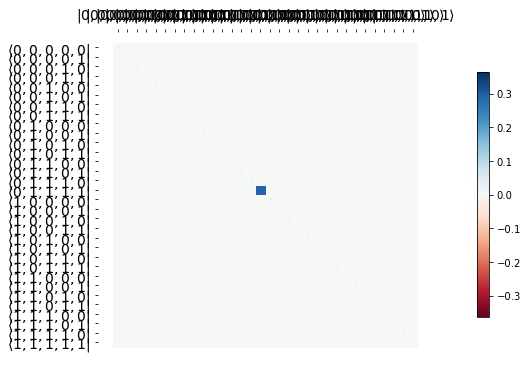

In [3]:
N = 5; x = .7
psi1_list = []
psi1_list.append(qutip.basis(2,0))
for n in range(N-1):
    psi1_list.append(qutip.basis(2,1))

psi0 = qutip.tensor(psi1_list)
rho0 = me.initial_state(N, False, None, x, None, psi0, True)
rho0

In [4]:
HS_modified = True

class Result(object):
      def __init__(self, ts=None, states=None):
        self.ts = ts
        self.states = states
        self.projrho0_app = None   
        self.projrho_inst_app = None 

def callback(t, rhot):
    global rho
    rho = rhot

def projected_evolution(N, chain_type = "XXX", unitary_ev = False, author=True, x=.5, 
                        gamma = 1*np.e*-2, omega_1=3., omega_2=3., temp=1, 
                        gaussian=False, gr = 1, deltat=10., tmax = 500., distance=me.bures, 
                        do_project=True):
    
    Jx = .15; Jy = .25; Jz = .1; h = 1.

    global rho
    loc_globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])

    if (gaussian and gr == 1):
        a = len(me.one_body_spin_ops(N))
        b = len(me.one_body_spin_ops(N)[0])
        coeffs_me1_gr1 = 10**-2.5 * np.full((a,b), 1)
        rho0 = me.initial_state(N, True, 1, None, coeffs_me1_gr1, None, False)
        
    elif(gaussian and gr == 2):
        a = len(me.all_two_body_spin_ops(N))
        b = len(me.all_two_body_spin_ops(N)[0])

        coeffs_me2_gr2 = 10**-3 * np.full((a,b),1.)
        rho0 = me.initial_state(N, True, 2, None, coeffs_me2_gr2, None, False)
             
    elif(not gaussian):
        psi1_list = []
        psi1_list.append(qutip.basis(2,0))
        for n in range(N-1):
            psi1_list.append(qutip.basis(2,1))

        psi0 = qutip.tensor(psi1_list)
        rho0 = me.initial_state(N, False, None, x, None, psi0, False)
         
    if (author):
        basis = me.base_orth(me.n_body_basis(2, N), rho0)  ## // Á la Tom
    else: 
        lista_ampliada = []
        for i in range(len(me.n_body_basis(1, N))):
            lista_ampliada.append(qutip.tensor(me.n_body_basis(N,1)[i], qutip.qeye(2)))
        basis = me.base_orth(lista_ampliada, rho0) ## // Á la Mauricio
    
    x_op, p_op, comm_xp, corr_xp, p_dot = me.classical_ops(chain_type, N, Jx, Jy, Jz, h)
    
    obs = [x_op, p_op, comm_xp, corr_xp, p_dot]
          #, x_op**2,p_op**2, corr_op, p_dot]
        
    sampling = max(int(10*max(1,omega_1, omega_2)*deltat), 10)
    print("sampling:", sampling)
    
    if unitary_ev: 
        c_op_list = None
    else:
        c_op_list = me.spin_dephasing(N, gamma)
        
    rho = rho0                                                               ## // Á la Mauricio
    approx_exp_vals = [[qutip.expect(op, rho) for op in obs]]
    ts= [0]

    for i in range(int(tmax/deltat)):
        qutip.mesolve(H=me.Heisenberg_Hamiltonian(chain_type, N, False, Jx, Jy, Jz, h), 
                               rho0=rho, 
                               tlist=np.linspace(0,deltat, sampling), 
                               c_ops=c_op_list, 
                               e_ops=callback,
                               args={'gamma': gamma,'omega_1': omega_1, 'omega_2': omega_2}
                               )
        ts.append(deltat*i)
        if do_project:
            rho = me.proj_op(me.logM(rho), basis, rho0)
            #rho = me.proj_op(me.logM(rho), basis, loc_globalid)
            e0 = max(rho.eigenenergies())
            rho = rho - loc_globalid * e0
            rho = rho.expm()
            trrho = (2.*rho.tr())
            rho = (rho+rho.dag())/trrho

        #print(qutip.entropy.entropy_vn(rho))
        newobs = [qutip.expect(rho, op) for op in obs]
        approx_exp_vals.append(newobs)

    result = {}
    result["ts"] = ts
    result["averages"] = np.array(approx_exp_vals)
    
    if unitary_ev:
        title = f"{chain_type}-chain closed ev/Proj ev for N={N} spins" 
    else:
        title = f"{chain_type}-chain open ev/Proj ev for N={N} spins" 

    #with open(title+".pkl","wb") as f:
    #    pickle.dump(result, f)
    return result, title

sampling: 30
sampling: 30


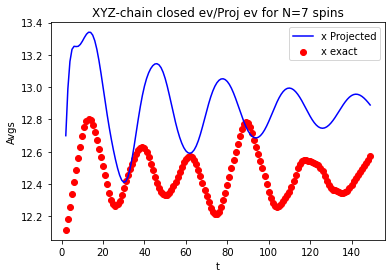

In [17]:
resultsA, title = projected_evolution(7, "XYZ", unitary_ev = True, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 150, distance=me.bures,do_project=True)

resultsB, title = projected_evolution(7, "XYZ", unitary_ev = True, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 150, distance=me.bures,do_project=False)

plt.plot(resultsA["ts"][3:], resultsA["averages"][:,0][3:], label="x Projected", color = "blue")
plt.scatter(resultsB["ts"][3:], resultsB["averages"][:,0][3:], label="x exact", color = "red")

plt.xlabel("t")
plt.ylabel("Avgs")

plt.title(title)
plt.legend()

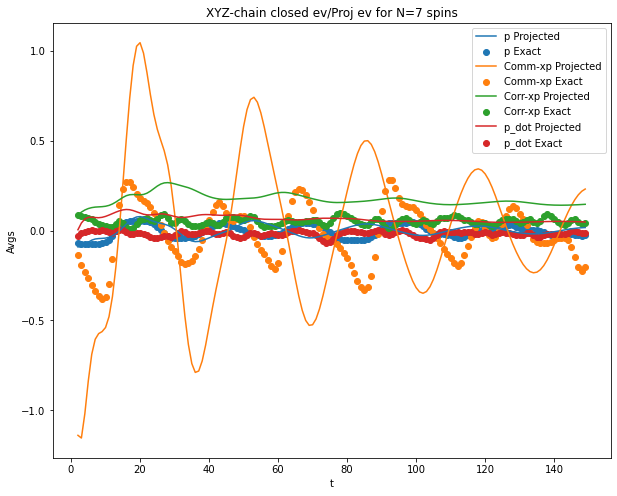

In [18]:
plot_labels = ["p ", "Comm-xp ", "Corr-xp ", "p_dot "]

plt.figure(figsize=(10, 8))
for n in range(4):
    plt.plot(resultsA["ts"][3:], resultsA["averages"][:,n+1][3:], label=plot_labels[n] + "Projected")
    plt.scatter(resultsB["ts"][3:], resultsB["averages"][:,n+1][3:], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

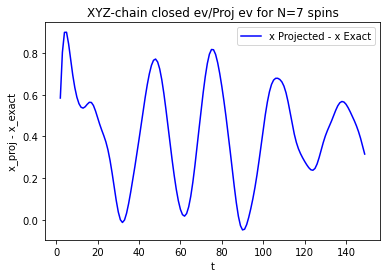

In [19]:
plt.plot(resultsA["ts"][3:], resultsA["averages"][:,0][3:]-resultsB["averages"][:,0][3:], label="x Projected - x Exact",
        color = "blue")

plt.xlabel("t")
plt.ylabel("x_proj - x_exact")

plt.title(title)
plt.legend()

sampling: 30
sampling: 30


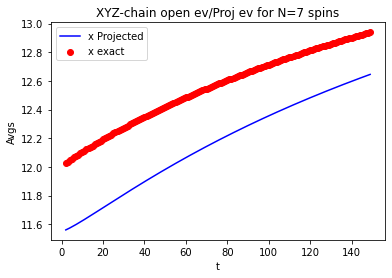

In [9]:
resultsA, title = projected_evolution(7, "XYZ", unitary_ev = False, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 150, distance=me.bures,do_project=True)

resultsB, title = projected_evolution(7, "XYZ", unitary_ev = False, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 150, distance=me.bures,do_project=False)

plt.plot(resultsA["ts"][3:], resultsA["averages"][:,0][3:], label="x Projected", color = "blue")
plt.scatter(resultsB["ts"][3:], resultsB["averages"][:,0][3:], label="x exact", color = "red")

plt.xlabel("t")
plt.ylabel("Avgs")

plt.title(title)
plt.legend()

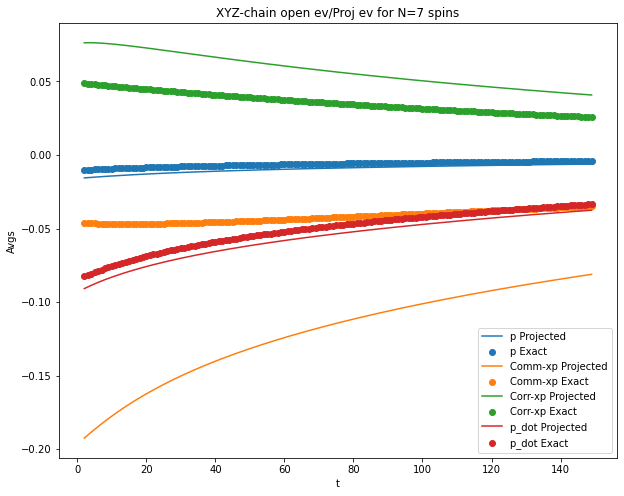

In [14]:
plot_labels = ["p ", "Comm-xp ", "Corr-xp ", "p_dot "]

plt.figure(figsize=(10, 8))
for n in range(4):
    plt.plot(resultsA["ts"][3:], resultsA["averages"][:,n+1][3:], label=plot_labels[n] + "Projected")
    plt.scatter(resultsB["ts"][3:], resultsB["averages"][:,n+1][3:], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

sampling: 30
sampling: 30


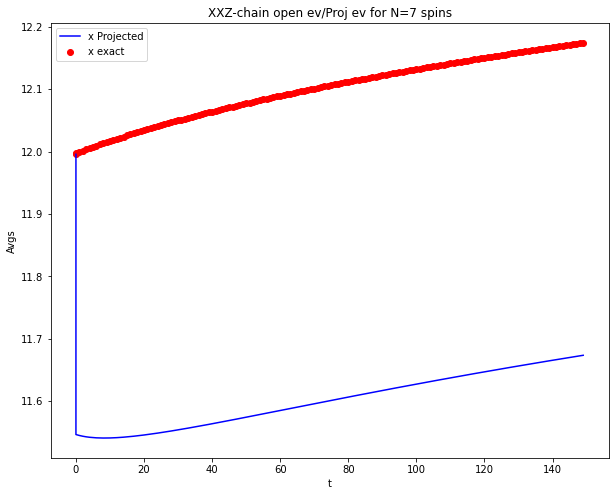

In [15]:
resultsA, title = projected_evolution(7, "XXZ", unitary_ev = False, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 150, distance=me.bures,do_project=True)

resultsB, title = projected_evolution(7, "XXZ", unitary_ev = False, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 150, distance=me.bures,do_project=False)

plt.figure(figsize=(10, 8))
plt.plot(resultsA["ts"], resultsA["averages"][:,0], label="x Projected", color = "blue")
plt.scatter(resultsB["ts"], resultsB["averages"][:,0], label="x exact", color = "red")

plt.xlabel("t")
plt.ylabel("Avgs")

plt.title(title)
plt.legend()

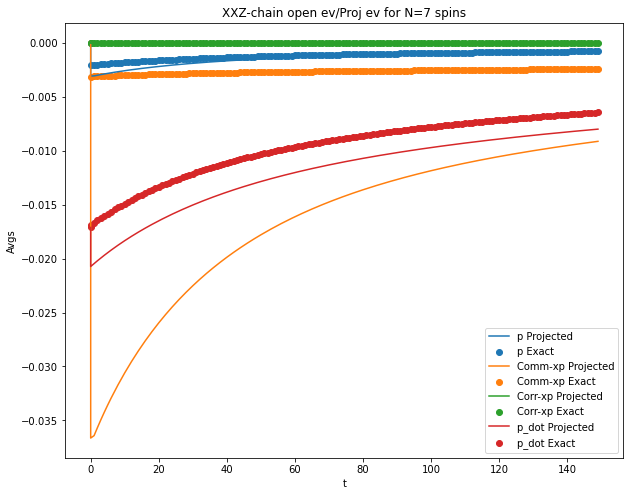

In [16]:
plot_labels = ["p ", "Comm-xp ", "Corr-xp ", "p_dot "]

plt.figure(figsize=(10, 8))
for n in range(4):
    plt.plot(resultsA["ts"], resultsA["averages"][:,n+1], label=plot_labels[n] + "Projected")
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n+1], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

In [ ]:
resultsA, title = projected_evolution(7, "XXX", unitary_ev = False, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 150, distance=me.bures,do_project=True)

resultsB, title = projected_evolution(7, "XXX", unitary_ev = False, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 150, distance=me.bures,do_project=False)

plt.figure(figsize=(10, 8))
plt.plot(resultsA["ts"], resultsA["averages"][:,0], label="x Projected", color = "blue")
plt.scatter(resultsB["ts"], resultsB["averages"][:,0], label="x exact", color = "red")

plt.xlabel("t")
plt.ylabel("Avgs")

plt.title(title)
plt.legend()

In [ ]:
plot_labels = ["p ", "Comm-xp ", "Corr-xp ", "p_dot "]

plt.figure(figsize=(10, 8))
for n in range(4):
    plt.plot(resultsA["ts"], resultsA["averages"][:,n+1], label=plot_labels[n] + "Projected")
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n+1], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

sampling: 30
sampling: 30


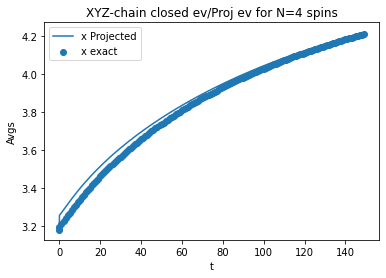

In [37]:
resultsA, title = projected_evolution(4, "XYZ", unitary_ev = False, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 150, distance=me.bures,do_project=True)

plt.plot(resultsA["ts"], resultsA["averages"][:,0], label="x Projected")
resultsB, title = projected_evolution(4, "XYZ", unitary_ev = False, author = True, x=.7, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 150, distance=me.bures,do_project=False)
plt.scatter(resultsB["ts"], resultsB["averages"][:,0], label="x exact")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)

plt.legend()

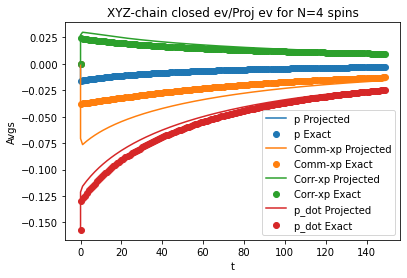

In [38]:
plot_labels = ["p ", "Comm-xp ", "Corr-xp ", "p_dot "]

for n in range(4):
    plt.plot(resultsA["ts"], resultsA["averages"][:,n+1], label=plot_labels[n] + "Projected")
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n+1], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

sampling: 30
sampling: 30


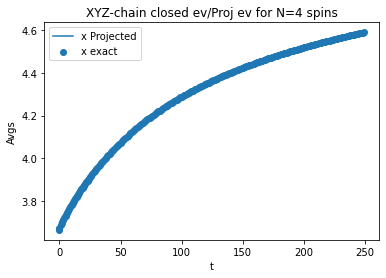

In [39]:
resultsA, title = projected_evolution(4, "XYZ", unitary_ev = False, author = True, x=.5, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 250, distance=me.bures,do_project=True)

plt.plot(resultsA["ts"], resultsA["averages"][:,0], label="x Projected")
resultsB, title = projected_evolution(4, "XYZ", unitary_ev = False, author = True, x=.5, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 250, distance=me.bures,do_project=False)
plt.scatter(resultsB["ts"], resultsB["averages"][:,0], label="x exact")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)

plt.legend()

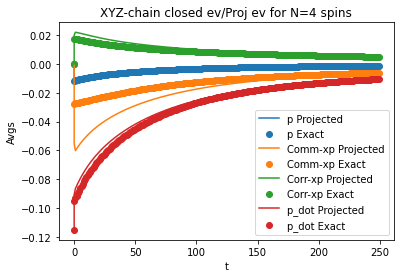

In [40]:
plot_labels = ["p ", "Comm-xp ", "Corr-xp ", "p_dot "]

for n in range(4):
    plt.plot(resultsA["ts"], resultsA["averages"][:,n+1], label=plot_labels[n] + "Projected")
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n+1], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

sampling: 30
sampling: 30


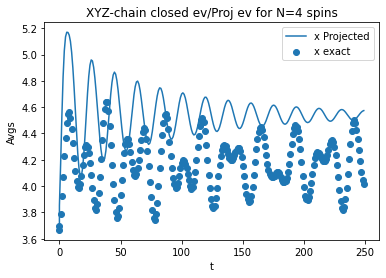

In [41]:
resultsA, title = projected_evolution(4, "XYZ", unitary_ev = True, author = True, x=.5, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 250, distance=me.bures,do_project=True)

plt.plot(resultsA["ts"], resultsA["averages"][:,0], label="x Projected")
resultsB, title = projected_evolution(4, "XYZ", unitary_ev = True, author = True, x=.5, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 250, distance=me.bures,do_project=False)
plt.scatter(resultsB["ts"], resultsB["averages"][:,0], label="x exact")
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)

plt.legend()

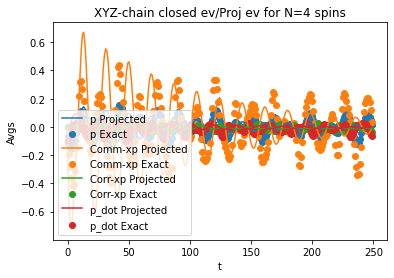

In [42]:
plot_labels = ["p ", "Comm-xp ", "Corr-xp ", "p_dot "]

for n in range(4):
    plt.plot(resultsA["ts"], resultsA["averages"][:,n+1], label=plot_labels[n] + "Projected")
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n+1], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

sampling: 30
sampling: 30


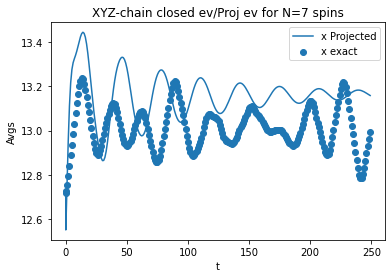

In [33]:
results, title = projected_evolution(7, "XYZ", unitary_ev = True, author = True, x=.5, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 250, distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results, title = projected_evolution(7, "XYZ", unitary_ev = True, author = True, x=.5, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 250, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)

plt.legend()

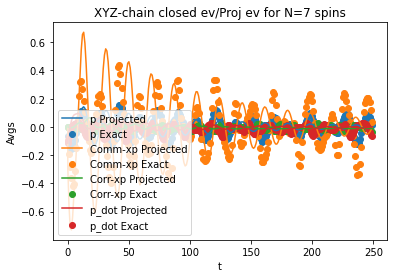

In [34]:
plot_labels = ["p ", "Comm-xp ", "Corr-xp ", "p_dot "]

for n in range(4):
    plt.plot(resultsA["ts"], resultsA["averages"][:,n+1], label=plot_labels[n] + "Projected")
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n+1], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

sampling: 30
sampling: 30


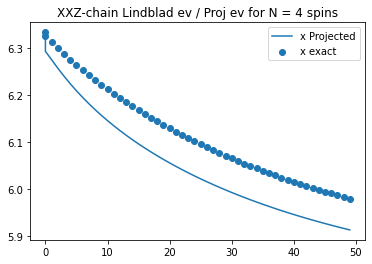

In [6]:
## estado inicial |--...-+>

results = projected_evolution(4, "XXZ", author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(4, "XXZ", author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
plt.title("XXZ-chain Lindblad ev / Proj ev for N = 4 spins")
plt.legend()

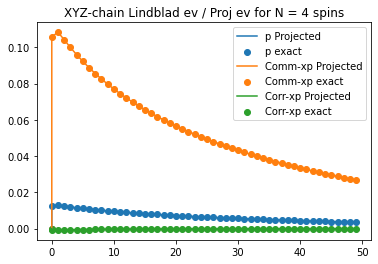

In [7]:
plt.plot(results["ts"], results["averages"][:,1], label="p Projected")
plt.scatter(results["ts"], results["averages"][:,1], label="p exact")
plt.plot(results["ts"], results["averages"][:,2], label="Comm-xp Projected")
plt.scatter(results["ts"], results["averages"][:,2], label="Comm-xp exact")
plt.plot(results["ts"], results["averages"][:,3], label="Corr-xp Projected")
plt.scatter(results["ts"], results["averages"][:,3], label="Corr-xp exact")

plt.title("XYZ-chain Lindblad ev / Proj ev for N = 4 spins")
plt.legend()

sampling: 30
sampling: 30


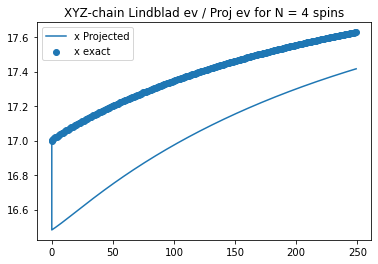

In [10]:
resultsA = projected_evolution(8, "XYZ", unitary_ev = False, author = True, x=.5, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 250, distance=me.bures,do_project=True)

plt.plot(resultsA["ts"], resultsA["averages"][:,0], label="x Projected")
resultsB = projected_evolution(8, "XYZ", unitary_ev = False, author = True, x=.5, 
                              gamma = 3*np.e*-1, omega_1=3., omega_2=3., temp=1, gaussian=False, 
                              gr = None, deltat=1, tmax = 250, distance=me.bures,do_project=False)
plt.scatter(resultsB["ts"], resultsB["averages"][:,0], label="x exact")
plt.title("XYZ-chain Lindblad ev / Proj ev for N = 4 spins")
plt.legend()

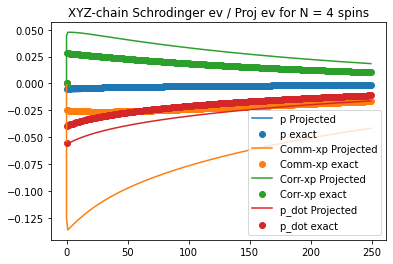

In [11]:
plt.plot(resultsA["ts"], resultsA["averages"][:,1], label="p Projected")
plt.scatter(resultsB["ts"], resultsB["averages"][:,1], label="p exact")
plt.plot(resultsA["ts"], resultsA["averages"][:,2], label="Comm-xp Projected")
plt.scatter(resultsB["ts"], resultsB["averages"][:,2], label="Comm-xp exact")
plt.plot(resultsA["ts"], resultsA["averages"][:,3], label="Corr-xp Projected")
plt.scatter(resultsB["ts"], resultsB["averages"][:,3], label="Corr-xp exact")
plt.plot(resultsA["ts"], resultsA["averages"][:,4], label="p_dot Projected")
plt.scatter(resultsB["ts"], resultsB["averages"][:,4], label="p_dot exact")

plt.title("XYZ-chain Schrodinger ev / Proj ev for N = 4 spins")
plt.legend()